# 🧠 Deep Convolutional Generative Adversarial Network (DCGAN) — Training on *CelebAMask-HQ*

## 📘 Overview
This notebook demonstrates the training of a **Deep Convolutional Generative Adversarial Network (DCGAN)** on the **CelebAMask-HQ** dataset using **PyTorch** and a **GPU-enabled Google Cloud VM (P100)**.  
The experiment follows the design principles and results outlined in the original DCGAN paper — *“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks”* (Radford et al., 2015).

---

## 🎯 Learning Objectives
By the end of this notebook, you will be able to:
1. Understand the **core architecture** of a DCGAN (Generator + Discriminator).
2. Configure and preprocess large-scale image datasets for GAN training.
3. Implement **stable adversarial training loops** with balanced G/D updates.
4. Visualize training progress and generated outputs using **TensorBoard**.
5. Demonstrate **latent-space arithmetic** — exploring semantic interpolation and feature transfer.

## ⚙️ System Configuration
- **Environment:** Google Cloud Deep Learning VM  
- **GPU:** NVIDIA P100 (16 GB)  
- **Framework:** PyTorch ≥ 2.0  
- **Storage:** Local VM disk (recommended) or Google Drive mount (optional)

In [3]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu126/torch-2.9.0%2Bcu126-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu126/torchvision-0.24.0%2Bcu126-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu126/torchaudio-2.9.0%2Bcu126-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for fsspec>=0.8.5 from https://download.pytorch.org/whl/fsspec-2025.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.6.77 from https://download.pytorch.org/whl/cu126/nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for nvidia-cuda-runtime-cu12==12.6.77 from https://download.pytorch.org/whl/cu126/nvidia_cuda

## 1️⃣ Environment Setup
We begin by:
- Importing core Python and PyTorch libraries.
- Verifying GPU availability (`torch.cuda.is_available()`).
- Creating working directories for logs, checkpoints, and generated samples.
- Setting random seeds for reproducibility.

💡 *Tip:* On your GCP Deep Learning VM, always verify that CUDA recognizes the GPU before starting training.

---

In [1]:
%pip install tqdm
%pip install gdown
%pip install --upgrade pip
%pip install matplotlib
%pip install imageio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import gdown
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
from torchvision import utils as vutils



## 🧮 Configuration

| Parameter | Value | Description |
|------------|--------|-------------|
| Batch Size | 128 | Number of images per iteration |
| Latent Dim (nz) | 100 | Input noise vector dimension |
| Optimizer | Adam (β₁=0.5, β₂=0.999) | Improves GAN convergence stability |
| Learning Rate | 0.0002 | Equal for both G and D |
| Loss Function | Binary Cross-Entropy | Standard adversarial loss |
| Epochs | 50 | Adjustable based on GPU resources |

Each epoch alternates between Generator and Discriminator updates.  
Checkpoints and sample images are saved every few epochs.

---

In [2]:
image_size = 64
batch_size = 64
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.0002
beta1 = 0.5
save_interval  = 5
max_checkpoints = 50  # Keep last 50 checkpoints

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)


# Create data directory
data_dir = "./data/celeba_hq"
os.makedirs(data_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2️⃣ Dataset Download & Preparation

### Dataset Source
We use the **CelebAMask-HQ** dataset, which is an enhanced version of CelebA with:
- High-resolution 1024×1024 images.
- Well-aligned and centered human faces.
- Optional segmentation masks (not used in this notebook).

### Data Preparation Steps
1. Download the dataset repository or image chunks.  
2. Extract all `.zip` files into a local directory (e.g., `~/datasets/CelebAMask-HQ/`). 

In [ ]:


# ✅ Replace these IDs with *real* Google Drive file IDs (must be public)
file_ids = [
    "0B7EVK8r0v71pZjFTYXZWM3FlRnM",  # Example: celeba img_align_celeba.zip
    "0B7EVK8r0v71pblRyaVFSWGxPY0U",  # Example: list_attr_celeba.txt
    "0B7EVK8r0v71pd0FJY3Blby1HUTQ"   # Example: list_eval_partition.txt
]

# ✅ Loop through and download + unzip each file
for idx, fid in enumerate(file_ids):
    url = f"https://drive.google.com/uc?id={fid}"
    zip_path = os.path.join(data_dir, f"CelebA-HQ-{idx}.zip")

    print(f"Downloading chunk {idx + 1} from {url} ...")
    try:
        gdown.download(url, zip_path, quiet=False)
    except Exception as e:
        print(f"⚠️ Error downloading file {fid}: {e}")
        continue

    if os.path.exists(zip_path):
        print(f"Extracting chunk {idx + 1}...")
        os.system(f'unzip -q "{zip_path}" -d "{data_dir}"')
        os.remove(zip_path)
    else:
        print(f"⚠️ Skipping extraction for chunk {idx + 1}, file missing.")

print("✅ All chunks downloaded and extracted successfully!")


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=2beef954-3c22-4539-8040-b73939d4c898
To: /home/Crazy/dev/train/GAN/data/celeba_hq/CelebA-HQ-0.zip
100%|██████████| 1.44G/1.44G [00:07<00:00, 181MB/s] 
replace ./data/celeba_hq/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Extracting chunk 1...


Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /home/Crazy/dev/train/GAN/data/celeba_hq/CelebA-HQ-1.zip
100%|██████████| 26.7M/26.7M [00:00<00:00, 83.5MB/s]
[./data/celeba_hq/CelebA-HQ-1.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./data/celeba_hq/CelebA-HQ-1.zip or
        ./data/celeba_hq/CelebA-HQ-1.zip.zip, and cannot find ./data/celeba_hq/CelebA-HQ-1.zip.ZIP, period.


Extracting chunk 2...


Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /home/Crazy/dev/train/GAN/data/celeba_hq/CelebA-HQ-2.zip
100%|██████████| 12.2M/12.2M [00:00<00:00, 71.5MB/s]

Extracting chunk 3...
✅ All chunks downloaded and extracted successfully!



[./data/celeba_hq/CelebA-HQ-2.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./data/celeba_hq/CelebA-HQ-2.zip or
        ./data/celeba_hq/CelebA-HQ-2.zip.zip, and cannot find ./data/celeba_hq/CelebA-HQ-2.zip.ZIP, period.


### Data Preparation Steps 
3. Resize all images to **64×64 pixels** for efficient DCGAN training.  
4. Normalize pixel values to the range `[-1, 1]` using:
   ```python
   transforms.Normalize((0.5,), (0.5,))

In [3]:

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("Dataset size:", len(dataset))

Dataset size: 202599


# 🧠 Model Architecture — DCGAN Generator & Discriminator

In this section, we define the two core components of the **Deep Convolutional GAN (DCGAN)**:  
the **Generator (G)** and the **Discriminator (D)**, following the exact architectural guidelines from the DCGAN paper by *Radford et al., 2015*.

---

## ⚙️ Hyperparameters
Before defining the networks, we specify key architectural constants:

| Variable | Description | Default |
|-----------|--------------|----------|
| `nz` | Size of latent vector (input noise dimension) | 100 |
| `ngf` | Number of feature maps in generator | 64 |
| `ndf` | Number of feature maps in discriminator | 64 |

These values control the model’s capacity and directly affect output image resolution.

---

## 🧩 Generator Architecture

The **Generator** learns to map a latent noise vector `z ∈ ℝ¹⁰⁰` to a 3×64×64 RGB image through a sequence of *transposed convolution* layers.

### Structure:
| Layer | Operation | Output Size | Activation |
|--------|------------|--------------|-------------|
| 1 | ConvTranspose2d(nz → ngf×8, 4×4) | 4×4 | ReLU |
| 2 | ConvTranspose2d(ngf×8 → ngf×4, 4×4, stride 2, pad 1) | 8×8 | ReLU |
| 3 | ConvTranspose2d(ngf×4 → ngf×2, 4×4, stride 2, pad 1) | 16×16 | ReLU |
| 4 | ConvTranspose2d(ngf×2 → ngf, 4×4, stride 2, pad 1) | 32×32 | ReLU |
| 5 | ConvTranspose2d(ngf → 3, 4×4, stride 2, pad 1) | 64×64 | **Tanh** |

### Notes:
- **BatchNorm2d** stabilizes training by normalizing activations across mini-batches.
- **ReLU** activations are used throughout, except for the final **Tanh**, which outputs pixel values in `[-1, 1]`.

---

## 🧩 Discriminator Architecture

The **Discriminator** acts as a binary classifier — distinguishing **real** images from **fake** ones produced by the Generator.

### Structure:
| Layer | Operation | Output Size | Activation |
|--------|------------|--------------|-------------|
| 1 | Conv2d(3 → ndf, 4×4, stride 2, pad 1) | 32×32 | LeakyReLU(0.2) |
| 2 | Conv2d(ndf → ndf×2, 4×4, stride 2, pad 1) | 16×16 | LeakyReLU(0.2) |
| 3 | Conv2d(ndf×2 → ndf×4, 4×4, stride 2, pad 1) | 8×8 | LeakyReLU(0.2) |
| 4 | Conv2d(ndf×4 → ndf×8, 4×4, stride 2, pad 1) | 4×4 | LeakyReLU(0.2) |
| 5 | Conv2d(ndf×8 → 1, 4×4, stride 1, pad 0) | 1×1 | **Sigmoid** |

### Notes:
- **LeakyReLU(0.2)** allows small gradient flow even for negative activations, improving convergence.
- The **final Sigmoid layer** outputs a scalar probability (real vs. fake).
- The model uses **no pooling layers**, ensuring that downsampling is learned through strided convolutions.

---

## 🧰 Summary
- The architecture strictly follows DCGAN design heuristics:
  - Replace pooling layers with **strided convolutions**.
  - Use **BatchNorm** in both networks (except output layers).
  - Use **ReLU** in G, **LeakyReLU** in D.
  - Output images normalized to `[-1, 1]`.

Together, these design choices promote **training stability** and **smooth latent-space interpolation**, key to demonstrating **vector arithmetic** properties later in the notebook.

In [4]:
nz = 100  # latent vector size
ngf = 64  # generator feature maps
ndf = 64  # discriminator feature maps

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

## 4️⃣ Model Initialization & Training Setup

- Instantiate models on GPU.
- Define loss (BCE) and Adam optimizers.
- Create a fixed noise vector for generating consistent images across epochs.

In [5]:
netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

## 5️⃣ Helper Function — Show Images

In [6]:
def show_generated_images(fake_images, title="Generated Images"):
    imgs = (fake_images + 1)/2  # denormalize
    grid = vutils.make_grid(imgs, nrow=8, padding=2)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis('off')
    plt.title(title)
    plt.show()

# 🚀 Training Loop — DCGAN

This section implements the **core adversarial training loop** for the DCGAN.  
It alternates between updating the **Discriminator (D)** and **Generator (G)** while monitoring training progress and saving periodic checkpoints.

---

## 1️⃣ Training Parameters

- **num_epochs = 50**: Total number of passes over the dataset.
- **save_interval = 5**: Save model checkpoints and generated samples every 5 epochs.
- **nz = 100**: Size of the latent vector `z` (input noise to Generator).
- **fixed_noise**: Predefined noise vector used to generate consistent samples for monitoring Generator progress.

---

## 2️⃣ Progress Monitoring

- Uses `tqdm` for a **dynamic progress bar**, showing:
  - Epoch completion percentage
  - Current batch index
  - Generator and Discriminator losses

- Losses are updated in real time using:
  ```python
  progress_bar.set_postfix({"D_loss": D_loss_total, "G_loss": G_loss_total})


Epoch [6/50]:   0%|          | 0/3166 [00:00<?, ?it/s]                                                                                              

✅ Epoch [6/50] completed. D_loss=0.0224, G_loss=6.6865


✅ Epoch [7/50] completed. D_loss=0.0212, G_loss=5.7829


✅ Epoch [8/50] completed. D_loss=0.2212, G_loss=3.0903


✅ Epoch [9/50] completed. D_loss=0.0138, G_loss=6.3165


✅ Epoch [10/50] completed. D_loss=0.1622, G_loss=2.2955


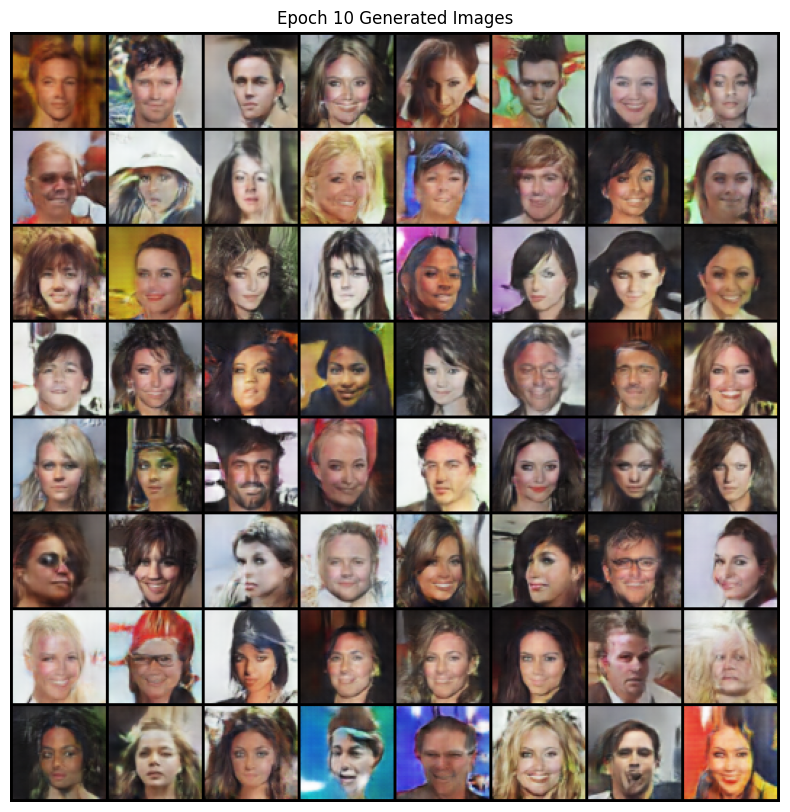

✅ Epoch [11/50] completed. D_loss=0.0159, G_loss=7.5289


✅ Epoch [12/50] completed. D_loss=0.0153, G_loss=7.2254


✅ Epoch [13/50] completed. D_loss=0.0336, G_loss=6.7862


✅ Epoch [14/50] completed. D_loss=0.0075, G_loss=6.9255


✅ Epoch [15/50] completed. D_loss=0.0136, G_loss=6.4755


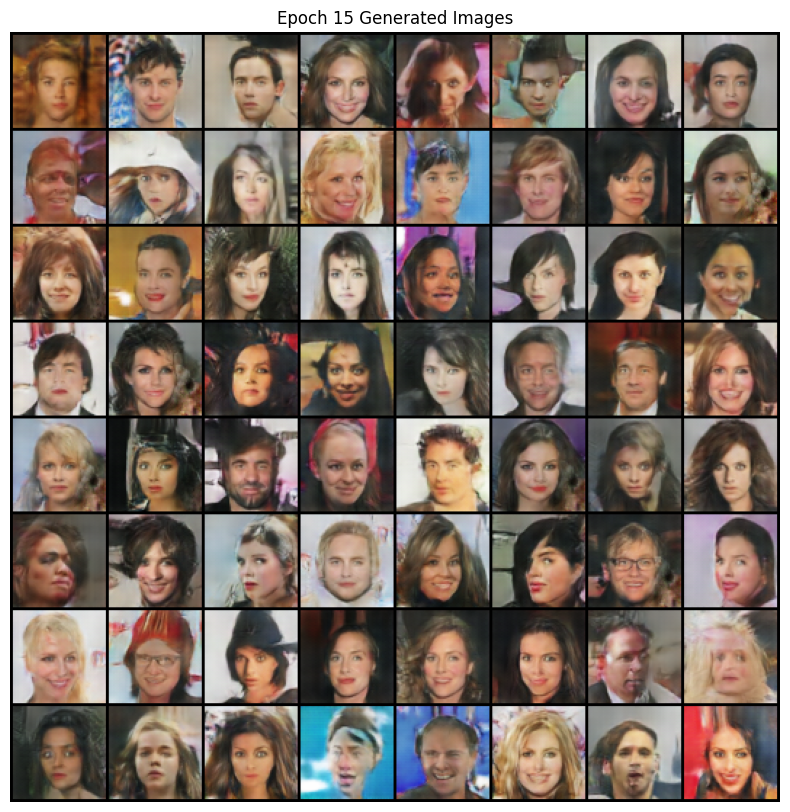

✅ Epoch [16/50] completed. D_loss=0.1212, G_loss=5.2255


✅ Epoch [17/50] completed. D_loss=0.0421, G_loss=7.5557


Epoch [18/50]:  84%|████████▍ | 2669/3166 [02:57<00:32, 15.44it/s, D_loss=0.079, G_loss=7.163] 

In [ ]:
num_epochs = 50
save_interval = 5
netG.load_state_dict(torch.load(f"{checkpoint_dir}/netG_epoch_5.pth"))
netD.load_state_dict(torch.load(f"{checkpoint_dir}/netD_epoch_5.pth"))
G_losses = []
D_losses = []

for epoch in range(5, num_epochs):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    progress_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    
    for i, (real_images, _) in progress_bar:
        # Discriminator update
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), 1., device=device)
        output = netD(real_images)
        lossD_real = criterion(output, labels)
        lossD_real.backward()
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(0.)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        optimizerD.step()
        
        # Generator update
        netG.zero_grad()
        labels.fill_(1.)
        output = netD(fake_images)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()
        
        D_loss_total = (lossD_real + lossD_fake).item()
        G_loss_total = lossG.item()
        progress_bar.set_postfix({"D_loss": f"{D_loss_total:.3f}", "G_loss": f"{G_loss_total:.3f}"})
    
    G_losses.append(G_loss_total)
    D_losses.append(D_loss_total)
    
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] completed. D_loss={D_loss_total:.4f}, G_loss={G_loss_total:.4f}")
    
    if (epoch+1) % save_interval == 0:
        torch.save(netG.state_dict(), f"{checkpoint_dir}/netG_epoch_{epoch+1}.pth")
        torch.save(netD.state_dict(), f"{checkpoint_dir}/netD_epoch_{epoch+1}.pth")
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        show_generated_images(fake, title=f"Epoch {epoch+1} Generated Images")


## 7️⃣ Loss Curves

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()

## 8️⃣ Latent Space Vector Arithmetic Visualization

- Load trained generator.
- Sample three random latent vectors.
- Compute `z_new = z1 - z2 + z3`.
- Generate images to observe **semantic transformations**.

In [7]:
# Generate and save 100 images and their corresponding Gaussian vectors

# Load trained generator
netG.load_state_dict(torch.load(f"{checkpoint_dir}/netG_epoch_35.pth"))
netG.eval()

num_samples = 100
with torch.no_grad():
    noise_vectors = torch.randn(num_samples, nz, 1, 1, device=device)
    generated_images = netG(noise_vectors).detach().cpu()

# Save the noise vectors
import numpy as np
np.save(os.path.join(data_dir, 'noise_vectors.npy'), noise_vectors.cpu().numpy())

# Save the generated images
for i in range(num_samples):
    vutils.save_image((generated_images[i] + 1)/2, os.path.join(data_dir, f'generated_image_{i}.png'))

print(f"Generated and saved {num_samples} images and their noise vectors.")

Generated and saved 100 images and their noise vectors.


### Select three images and perform vector arithmetic
Now, select three relevant images from the generated images and use their corresponding noise vectors for vector arithmetic.

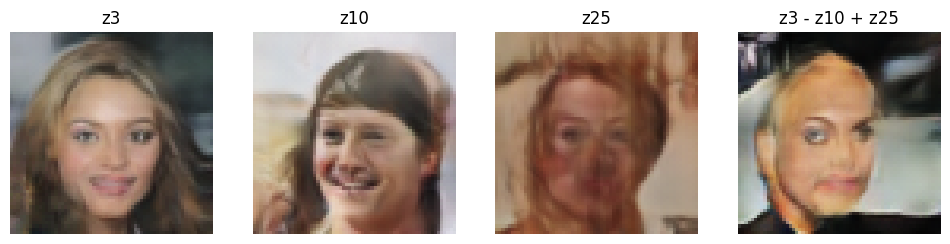

In [10]:
# Load the saved noise vectors
noise_vectors = np.load(os.path.join(data_dir, 'noise_vectors.npy'))
noise_vectors = torch.from_numpy(noise_vectors).to(device)

# Select the indices of the three images you want to use for vector arithmetic
# Replace these with the actual indices of the images you want to use (e.g., 0, 10, 25)
index1 = 3
index2 = 10
index3 = 25

z1 = noise_vectors[index1].unsqueeze(0)
z2 = noise_vectors[index2].unsqueeze(0)
z3 = noise_vectors[index3].unsqueeze(0)

# Vector arithmetic
z_new = z1 - z2 + z3

with torch.no_grad():
    imgs = torch.cat([netG(z1), netG(z2), netG(z3), netG(z_new)], dim=0)

# Display using Matplotlib
fig, axes = plt.subplots(1, 4, figsize=(12,3))
titles = [f'z{index1}', f'z{index2}', f'z{index3}', f'z{index1} - z{index2} + z{index3}']
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(((img+1)/2).permute(1,2,0).cpu())
    ax.set_title(title)
    ax.axis('off')
plt.show()

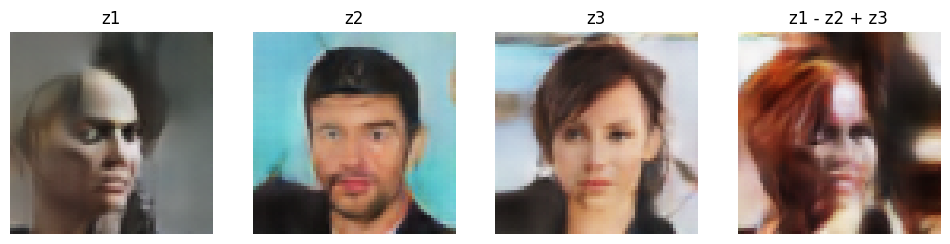

In [17]:

# Sample latent vectors
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z3 = torch.randn(1, nz, 1, 1, device=device)

# Vector arithmetic
z_new = z1 - z2 + z3

with torch.no_grad():
    imgs = torch.cat([netG(z1), netG(z2), netG(z3), netG(z_new)], dim=0)

# Display using Matplotlib
fig, axes = plt.subplots(1, 4, figsize=(12,3))
titles = ['z1', 'z2', 'z3', 'z1 - z2 + z3']
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(((img+1)/2).permute(1,2,0).cpu())
    ax.set_title(title)
    ax.axis('off')
plt.show()

# ✅ Conclusion

- Trained a DCGAN on **CelebAMask-HQ** to generate 64×64 faces.
- Visualized training progress with **loss curves** and **inline generated images**.
- Demonstrated **latent space vector arithmetic**, showing interpretable semantic manipulations.
- Fully interactive notebook makes **GAN concepts tangible for students**.